In [1]:
import keras
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import time
from PIL import Image


c:\users\ani\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_dataset(path):
    data = load_files(path)
    cancer_files = np.array(data['filenames'])
    cancer_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return cancer_files, cancer_targets

In [3]:
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

In [4]:
cancer_types = ([item[11:]for item in sorted(glob("data/train/*"))])

In [5]:
print('There are %d total skin cancer categories.' % len(cancer_types))
print('There are %s total skin cancer images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training skin cancer images.' % len(train_files))
print('There are %d validation skin cancer images.' % len(valid_files))
print('There are %d test skin cancer images.'% len(test_files))

There are 3 total skin cancer categories.
There are 1426 total skin cancer images.

There are 1002 training skin cancer images.
There are 107 validation skin cancer images.
There are 317 test skin cancer images.


In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [01:45<00:00,  3.00it/s]


In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import applications
from keras import optimizers, losses, activations, models

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint  

epochs = 25

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 1002 samples, validate on 107 samples
Epoch 1/25
 - 23s - loss: 0.9896 - acc: 0.5180 - val_loss: 3.1640 - val_acc: 0.3271

Epoch 00001: val_loss improved from inf to 3.16397, saving model to saved_models/weights.best.hdf5
Epoch 2/25
 - 20s - loss: 0.9506 - acc: 0.5609 - val_loss: 2.2535 - val_acc: 0.3364

Epoch 00002: val_loss improved from 3.16397 to 2.25347, saving model to saved_models/weights.best.hdf5
Epoch 3/25
 - 20s - loss: 0.8339 - acc: 0.5958 - val_loss: 1.7430 - val_acc: 0.3645

Epoch 00003: val_loss improved from 2.25347 to 1.74301, saving model to saved_models/weights.best.hdf5
Epoch 4/25
 - 20s - loss: 0.8264 - acc: 0.6068 - val_loss: 2.3588 - val_acc: 0.4299

Epoch 00004: val_loss did not improve from 1.74301
Epoch 5/25
 - 20s - loss: 0.8092 - acc: 0.6228 - val_loss: 3.5258 - val_acc: 0.3364

Epoch 00005: val_loss did not improve from 1.74301
Epoch 6/25
 - 20s - loss: 0.8127 - acc: 0.6188 - val_loss: 3.0812 - val_acc: 0.3271

Epoch 00006: val_loss did not improv

In [14]:
model.load_weights('saved_models/weights.best.hdf5')

In [15]:
cancer_type_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(cancer_type_predictions)==np.argmax(test_targets, axis=1))/len(cancer_type_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.7413%


In [16]:
print(cancer_type_predictions)

[1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


[[5.8589596e-28 1.0000000e+00 0.0000000e+00]]


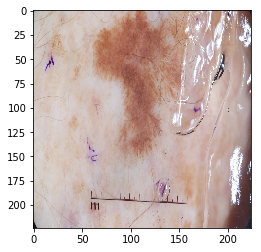

In [17]:
test_image = image.load_img('data/test/seborrheic_keratosis/ISIC_0012848.jpg', target_size = (224,224))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)